# Prelim

Dataset downloaded from : https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/1.0.0/pbmc_unsorted_10k


Data is available at `s3://fh-pi-setty-m-eco-public/single-cell-primers/multiome/`
Review the notebook `PBMC-RNA-standalone.ipynb` for setup instructions.

## Load data

Download all the multiome data using the following command

# Imports

In [13]:
import os
import pandas as pd
import numpy as np

In [14]:
import scanpy as sc
import pyranges as pr
import warnings

In [15]:
import palantir 
import phenograph
import harmony

In [16]:
import anndata as ad

In [17]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Utility functions

In [19]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [20]:
from joblib import Parallel, delayed
from scipy.sparse import hstack, csr_matrix, issparse
import gc

def _dot_func(x, y):
    return x.dot(y)


def impute_data(dm_res, ad, n_steps=3):
    T_steps = dm_res['T'] ** n_steps
    T_steps = T_steps.astype(np.float32)

    # RUn in parallel
    seq = np.append(np.arange(0, ad.X.shape[1], 100), [ad.X.shape[1]])
    res = Parallel(n_jobs=-1)(delayed(_dot_func)(T_steps, ad.X[:, seq[i - 1]:seq[i]]) for i in range(1, len(seq)))
    imputed_data = hstack(res)
    imputed_data = imputed_data.todense()
    imputed_data[imputed_data < 1e-2] = 0
    gc.collect()

    return imputed_data

# Load data

In [21]:
data_dir = '/fh/fast/setty_m/grp/lab-datasets/bonemarrow-tcell-dep-multiome/cr-arc-results/'

In [22]:
#combine replicates

samples = ['rep1', 'rep2']
rna_ad_dict, atac_ad_dict = dict(), dict()

for r in samples:
    comb_ad = sc.read_10x_h5(data_dir + r+ '/filtered_feature_bc_matrix.h5', gex_only=False)
    comb_ad.obs_names = 'tcell-dep-multiome_' + r + "#" + comb_ad.obs_names
    rna_ad_dict[r] = comb_ad[:, comb_ad.var['feature_types']=='Gene Expression']
    rna_ad_dict[r].var_names_make_unique()
    rna_ad_dict[r].obs['sample']= r
    
    atac_ad_dict[r] = comb_ad[:, comb_ad.var['feature_types'] == 'Peaks']
    atac_ad_dict[r].var_names_make_unique()
    

/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [23]:
sample_cells = dict()
for sample in samples:
    sample_cells[sample] = rna_ad_dict[sample].obs_names


In [27]:
#Per barcode metrics
bc_metrics_dict = dict ()
for sample in samples:
    bc_metrics_dict[sample] = pd.read_csv(data_dir + r +'/per_barcode_metrics.csv', index_col = 0)
    bc_metrics_dict[sample].index = 'tcell-dep-multiome_' + r + "#" +bc_metrics_dict[sample].index
    bc_metrics_dict[sample] = bc_metrics_dict[sample].loc[rna_ad_dict[sample].obs_names]
    
#FRIP
    bc_metrics_dict[sample]['FRIP'] = bc_metrics_dict[sample]['atac_peak_region_fragments']/bc_metrics_dict[sample]['atac_fragment']

KeyError: "None of [Index(['tcell-dep-multiome_rep1#AAACAGCCATGAATCT-1',\n       'tcell-dep-multiome_rep1#AAACATGCACATAGCC-1',\n       'tcell-dep-multiome_rep1#AAACATGCACCTATAG-1',\n       'tcell-dep-multiome_rep1#AAACATGCAGGAACTG-1',\n       'tcell-dep-multiome_rep1#AAACATGCATAATCAC-1',\n       'tcell-dep-multiome_rep1#AAACATGCATAATCCG-1',\n       'tcell-dep-multiome_rep1#AAACATGCATTGCGGT-1',\n       'tcell-dep-multiome_rep1#AAACCAACACAGCCTG-1',\n       'tcell-dep-multiome_rep1#AAACCGAAGACAAAGT-1',\n       'tcell-dep-multiome_rep1#AAACCGAAGATGCCTG-1',\n       ...\n       'tcell-dep-multiome_rep1#TTTGTGAAGCCGCAAC-1',\n       'tcell-dep-multiome_rep1#TTTGTGAAGGAAACTG-1',\n       'tcell-dep-multiome_rep1#TTTGTGAAGTTGTCTT-1',\n       'tcell-dep-multiome_rep1#TTTGTGGCAATGCCTA-1',\n       'tcell-dep-multiome_rep1#TTTGTGGCAGAGAGCC-1',\n       'tcell-dep-multiome_rep1#TTTGTGTTCAAACCTA-1',\n       'tcell-dep-multiome_rep1#TTTGTGTTCATGCAAC-1',\n       'tcell-dep-multiome_rep1#TTTGTTGGTACTGAAT-1',\n       'tcell-dep-multiome_rep1#TTTGTTGGTCGCGCAA-1',\n       'tcell-dep-multiome_rep1#TTTGTTGGTTGAATCG-1'],\n      dtype='object', length=6305)] are in the [index]"

In [ ]:
# Barcode metrics
#bc_metrics = pd.read_csv(data_dir + '/pbmc_unsorted_10k_per_barcode_metrics.csv', index_col=0)
#bc_metrics.index = 'pbmc_multiome' + '#' +bc_metrics.index 

# FRIP
#bc_metrics['FRIP'] = bc_metrics['atac_peak_region_fragments']/bc_metrics['atac_fragments']

In [ ]:
# Separate RNA and ATAC components
rna_ad = sc.read(data_dir + 'bm_multiome_rna_no_bcells.h5ad')#comb_ad[:, comb_ad.var['feature_types'] == 'Gene Expression']
rna_ad.var_names_make_unique()

atac_ad = sc.read(data_dir +'bm_multiome_atac_no_bcells.h5ad')
atac_ad.var_names_make_unique()

In [ ]:
rna_ad

In [ ]:
atac_ad

In [15]:
sample_cells = rna_ad.obs_names

# Preprocess

This section follows the preprocessing steps of the single-cell RNA-seq analysis 

In [16]:
ad = rna_ad

## QC

In [17]:
ad.var['mt'] = ad.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], inplace=True, percent_top=None, log1p=False, )

### Filter cell based on RNA

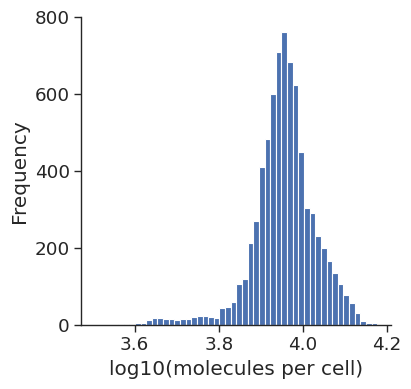

In [18]:
plt.figure()
ax = plt.gca()
ax.hist(np.log10(ad.obs['total_counts']), 50)
ax.set_xlabel('log10(molecules per cell)')
ax.set_ylabel('Frequency')
sns.despine()

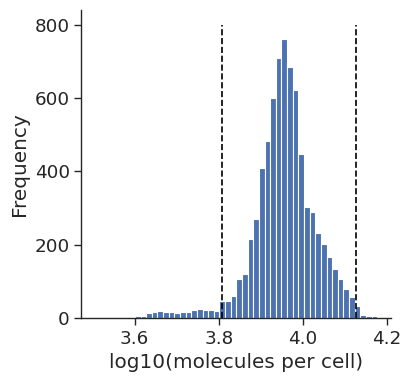

In [19]:
# Manually adjust the threshold percentage depending on the dataset
# Doublet detection (Eg: scrublet) will work better for higher molecule count cells
THRESHOLDS = np.log10(np.percentile((ad.obs['total_counts']), [3.5, 99.5]))

plt.figure()
ax = plt.gca()
ax.hist(np.log10(ad.obs['total_counts']), 50)
ax.vlines(THRESHOLDS, ax.get_ylim()[0], ax.get_ylim()[1], color='black', linestyle='--')
ax.set_xlabel('log10(molecules per cell)')
ax.set_ylabel('Frequency')
sns.despine()

In [20]:
# Filter cells 
sample_cells = sample_cells[(np.log10(ad.obs['total_counts'][sample_cells]) > THRESHOLDS[0]) & \
    (np.log10(ad.obs['total_counts'][sample_cells]) < THRESHOLDS[1]) ]


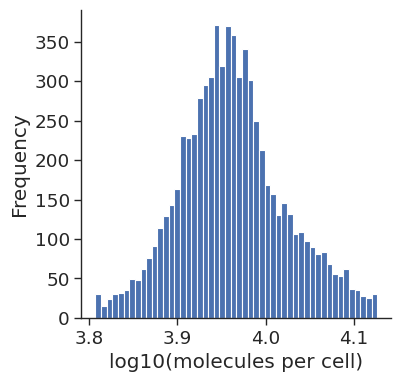

In [21]:
plt.figure()
ax = plt.gca()
ax.hist(np.log10(ad.obs['total_counts'][sample_cells]), 50)
ax.set_xlabel('log10(molecules per cell)')
ax.set_ylabel('Frequency')
sns.despine()

### Filter based on ATAC

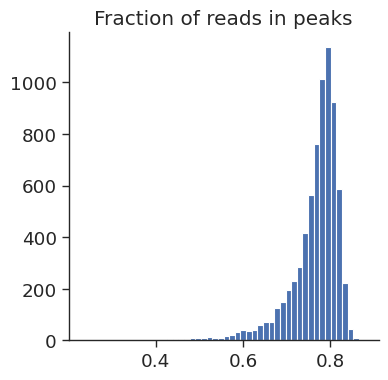

In [22]:
## CAUTION: CellRanger peak calling is unreliable and we only use it here to filter cells with low 
##          fraction of reads in peaks. This is ok since CellRanger peak caller dramatically over estimates 
##          the peak widths. We might incur some false negatives, but thats an acceptable error for filtering   
plt.figure()
ax = plt.gca()
ax.hist(atac_ad.obs['FRIP'][sample_cells], 50)
plt.title('Fraction of reads in peaks')
sns.despine()

In [23]:
THRESHOLD = 0.4
sample_cells = sample_cells[atac_ad.obs['FRIP'][sample_cells] > THRESHOLD]

### Filter based on mitochondria

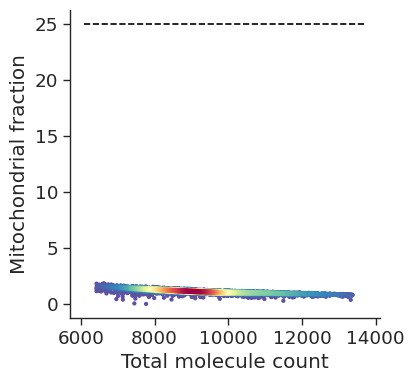

In [24]:
MITO_THRESHOLD = 25

x,y,dens = palantir.plot.density_2d(ad.obs['total_counts'][sample_cells], 
               ad.obs['pct_counts_mt'][sample_cells])

plt.figure()
ax = plt.gca()
ax.scatter(x, y, c=dens, s=5)
ax.hlines(MITO_THRESHOLD, ax.get_xlim()[0], ax.get_xlim()[1], color='black', linestyle='--')

plt.xlabel('Total molecule count')
plt.ylabel('Mitochondrial fraction')
sns.despine()


In [25]:
sample_cells = sample_cells[ad.obs['pct_counts_mt'][sample_cells] < MITO_THRESHOLD]

In [26]:
ad = ad[sample_cells, :]
ad

View of AnnData object with n_obs × n_vars = 7130 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell', 'Metacell_Entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'DMEigenValues', 'celltype_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

## Analysis

In [27]:
# Filter genes 
sc.pp.filter_genes(ad, min_cells=50)

/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [28]:
# Normalize and log transform
sc.pp.normalize_per_cell(ad)
#log_transform(ad)

In [29]:
# Highly variable genes [Num. of genes is a paramter, typically 1.5-2.5k genes work well]
sc.pp.highly_variable_genes(ad, flavor='cell_ranger', n_top_genes=2500)
ad

AnnData object with n_obs × n_vars = 7130 × 15586
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell', 'Metacell_Entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'DMEigenValues', 'celltype_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [30]:
# PCA
sc.pp.pca(ad, use_highly_variable=True, n_comps=50)
ad
# 50 comps is an approxmiation here - choose number of components by knee point or fraction of explained variance

AnnData object with n_obs × n_vars = 7130 × 15586
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell', 'Metacell_Entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'DMEigenValues', 'celltype_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [31]:
# UMAP and Leiden - requires the computation of nearest neighbors
sc.pp.neighbors(ad, use_rep='X_pca')
sc.tl.umap(ad)
sc.tl.leiden(ad)
ad

AnnData object with n_obs × n_vars = 7130 × 15586
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell', 'Metacell_Entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'DMEigenValues', 'celltype_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [32]:
# Diffusion maps 
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(ad.obsm['X_pca'], index=ad.obs_names))
ad.obsp['DM_Kernel'] = dm_res['kernel']
ad.obsm['DM_EigenVectors'] = dm_res['EigenVectors'].values
ad.uns['DMEigenValues'] = dm_res['EigenValues'].values
ad

Determing nearest neighbor graph...


AnnData object with n_obs × n_vars = 7130 × 15586
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell', 'Metacell_Entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'DMEigenValues', 'celltype_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [33]:
# Phenograph 
ad.obs['phenograph'], _, _ = phenograph.cluster(ad.obsm['X_pca'])
ad.obs['phenograph'] = ad.obs['phenograph'].astype(str)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9759187698364258 seconds
Jaccard graph constructed in 1.5029864311218262 seconds
Wrote graph to binary file in 0.13138294219970703 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.81387
Louvain completed 21 runs in 4.500049114227295 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 9.438053131103516 seconds


In [34]:
# Imputation
ad.obsm['MAGIC_imputed_data'] = impute_data(dm_res, ad)

# Visualize results

In [35]:
ad.obs['log_n_counts'] = np.log10(ad.obs['total_counts'])

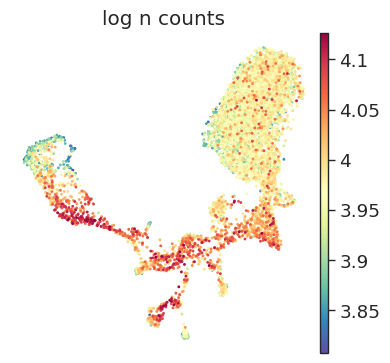

In [36]:
sc.pl.scatter(ad, basis='umap', color='log_n_counts', frameon=False)

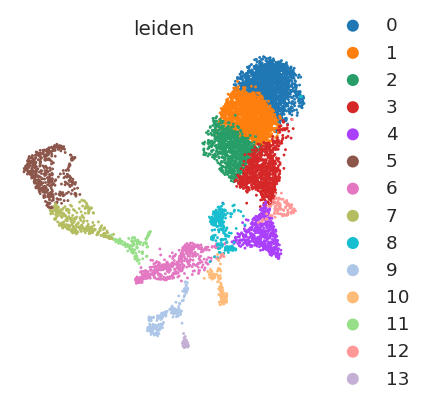

In [37]:
sc.pl.scatter(ad, basis='umap', color=['leiden'], frameon=False)

# Celltype annotation

In [38]:
genes = pd.Series([
    "CD34",  #Early Progenitor
    "GATA1", #Erythroid
    "PAX5", "MS4A1", "MME", #B-Cell Trajectory
    "CD14",  #Monocytes
    "CD3D", "CD8A", 'CD4', #TCells,
    'FCGR3A', #'CD16', 
     'LEF1', 'NKG7', 'TREM1', 'LYZ', 'CD19',  'IRF8', 'IRF4',
    'ITGA2B', # CD41,
    'NCAM1', # CD56,
    'CCR7' # Memory T cell
])
genes = genes[genes.isin(ad.var_names)]

In [39]:
imp_df = pd.DataFrame(ad.obsm['MAGIC_imputed_data'], 
                                                index=ad.obs_names, columns=ad.var_names)



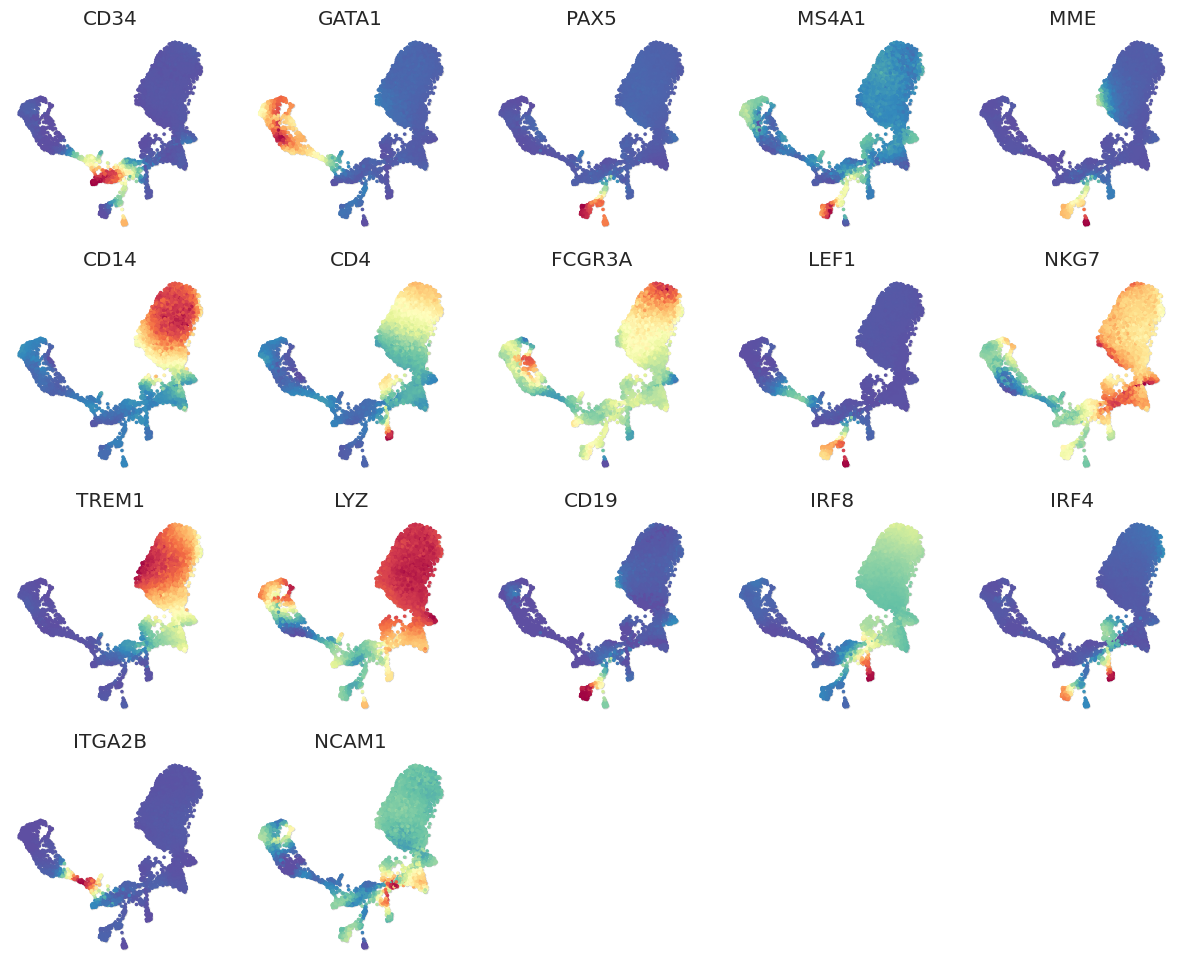

In [40]:
palantir.plot.plot_gene_expression(imp_df,
                                   pd.DataFrame(ad.obsm['X_umap'], 
                                               index=ad.obs_names, columns=['x', 'y']), 
                                   genes)

Cell type annotation can be performed using the same markers listed in https://github.com/settylab/single-cell-primers/blob/main/notebooks/PBMC-RNA-standalone.ipynb

# Save

In [41]:
#temp1 = atac_ad[ad.obs_names, :]
#temp = ad.concatenate(temp1)
#temp.var_names_make_unique()
#temp = temp[:, ad.var_names]

In [42]:
# Attach raw counts
#ad.raw = sc.AnnData(temp.X)

In [43]:
#out_dir = '/fh/fast/setty_m/user/cjordan2/repositories/single-cell-primers/data'
#ad.write(out_dir + 'tcell-dep_multiome_rna.h5ad')

In [44]:
# Export ce/fh/fast/setty_m/user/cjordan2/repositories/ of cells will be use for ATAC analysis
#pd.DataFrame(ad.obs_names).to_csv(out_dir + 'tcell-dep_multiome_cells.csv')